In [ ]:
!pip install trimesh
#triangle mesh - 3d - connect point clouds

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.8/690.8 kB 11.1 MB/s eta 0:00:00


In [ ]:
import os
import glob
import trimesh
import tensorflow as tf
from  tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(1234)

#downloading the MODELNET 10 dataset #3d DL models
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 [==============================] - 14s 0us/step


In [ ]:
mesh=trimesh.load(os.path.join(DATA_DIR,"chair/train/chair_0001.off"))
mesh.show()

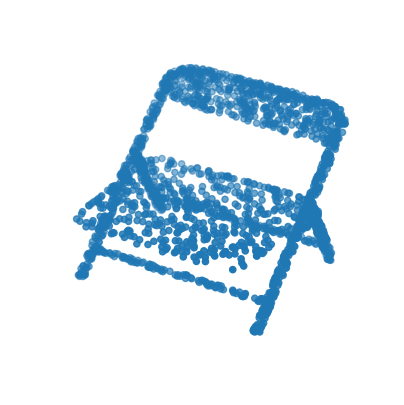

In [ ]:
# convert a mesh file to a point cloud : sample points on the mesh surface
# .sample performs a uniform random sampling. sample at 2048 locations and visualize in matplotlib
import matplotlib.pyplot as plt

points=mesh.sample(2048)
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111,projection="3d")
ax.scatter(points[:,0],points[:,1],points[:,2])
ax.set_axis_off()
plt.show()

In [ ]:
def parse_dataset(num_points=2048):
  train_points=[]
  train_labels=[]
  test_points=[]
  test_labels=[]
  class_map={}
  folders=glob.glob(os.path.join(DATA_DIR,"[!README]*"))

  for i , folder in enumerate(folders):
    print ("processing class:{}".format(os.path.basename(folder)))
    # store the folder name with ID : can retrieve later
    class_map[i]=folder.split("/")[-1]
    #gather all files
    train_files=glob.glob(os.path.join(folder,"train/*"))
    test_files=glob.glob(os.path.join(folder,"test/*"))
    for f in train_files:
      train_points.append(trimesh.load(f).sample(num_points))
      train_labels.append(i)
    for f in test_files:
      test_points.append(trimesh.load(f).sample(num_points))
      test_labels.append(i)
  return(
      np.array(train_points),
      np.array(test_points),
      np.array(train_labels),
      np.array(test_labels),
      class_map,
  )

In [ ]:
NUM_POINTS=2048
NUM_CLASSES=10
BATCH_SIZE=32
train_points,test_points,train_labels,test_labels,CLASS_MAP=parse_dataset(NUM_POINTS)

processing class:table
processing class:dresser
processing class:sofa
processing class:night_stand
processing class:chair
processing class:bed
processing class:bathtub
processing class:monitor
processing class:desk
processing class:toilet


In [ ]:
import tensorflow as tf

def augment(points, label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    points = tf.random.shuffle(points)  # Shuffle along the first axis (assuming points is a tensor)
    return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

# Shuffle and map the augment function for training dataset
train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)

# Shuffle and map the augment function for test dataset
test_dataset = test_dataset.shuffle(len(test_points)).map(augment).batch(BATCH_SIZE)


In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import tensorflow as tf
from tensorflow import keras

class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))


In [ ]:
def tnet(inputs, num_features):
    # Initialise bias as the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
import keras
from tensorflow import data as tf_data
from tensorflow.keras import initializers, layers  # Make sure to import layers from tensorflow.keras
# Define your model
NUM_POINTS = 1000  # Example value, adjust as needed
NUM_CLASSES = 10  # Example value, adjust as needed


inputs = keras.Input(shape=(2048, 3))
x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 2048, 3)]            0         []                            
                                                                                                  
 conv1d_22 (Conv1D)          (None, 2048, 32)             128       ['input_29[0][0]']            
                                                                                                  
 batch_normalization_95 (Ba  (None, 2048, 32)             128       ['conv1d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_95 (Activation)  (None, 2048, 32)             0         ['batch_normalization_9

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["sparse_categorical_accuracy"],)
model.fit(train_dataset,epochs=10,validation_data=test_dataset)

Epoch 1/10
125/125 [==============================] - 34s 164ms/step - loss: 2.6724 - sparse_categorical_accuracy: 0.4833 - val_loss: 1990066568251310080.0000 - val_sparse_categorical_accuracy: 0.3822
Epoch 2/10
125/125 [==============================] - 20s 159ms/step - loss: 2.5324 - sparse_categorical_accuracy: 0.5580 - val_loss: 749512796667904.0000 - val_sparse_categorical_accuracy: 0.5716
Epoch 3/10
125/125 [==============================] - 20s 158ms/step - loss: 2.3899 - sparse_categorical_accuracy: 0.5886 - val_loss: 6181005819904.0000 - val_sparse_categorical_accuracy: 0.6189
Epoch 4/10
125/125 [==============================] - 19s 152ms/step - loss: 2.2338 - sparse_categorical_accuracy: 0.6279 - val_loss: 315613792.0000 - val_sparse_categorical_accuracy: 0.6123
Epoch 5/10
125/125 [==============================] - 19s 156ms/step - loss: 2.2029 - sparse_categorical_accuracy: 0.6490 - val_loss: 2.8610 - val_sparse_categorical_accuracy: 0.5396
Epoch 6/10
125/125 [=============

1/1 [==============================] - 1s 768ms/step


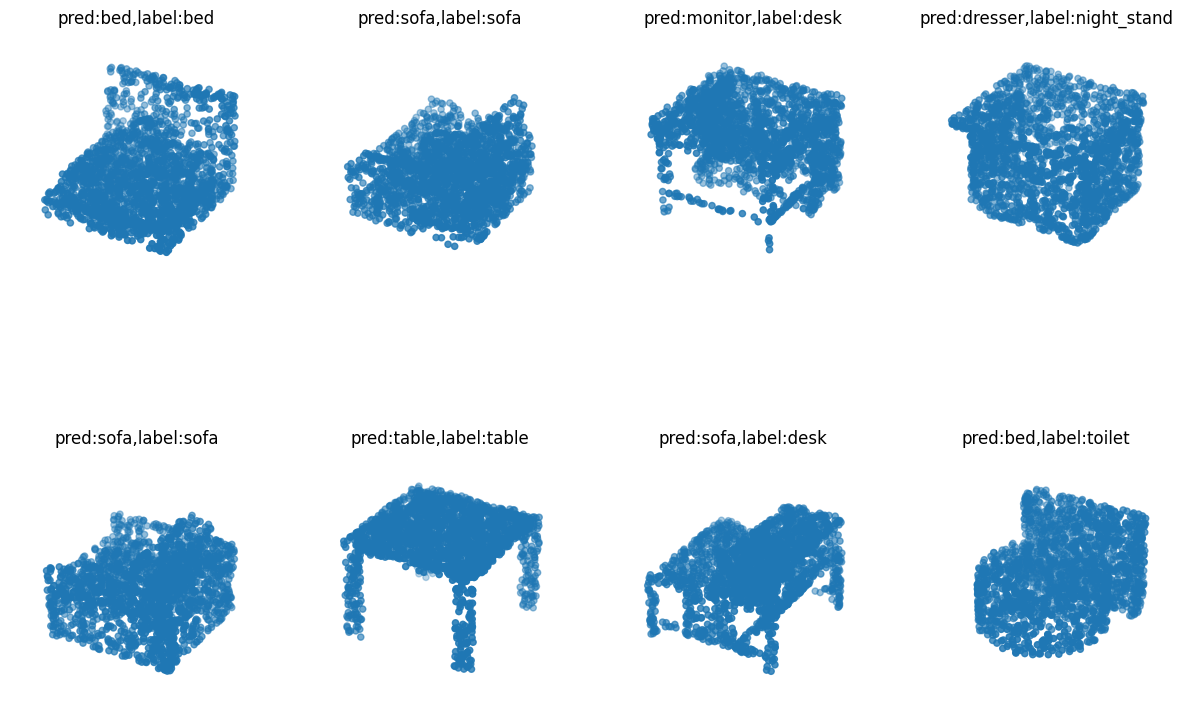

In [ ]:
data=test_dataset.take(1)
points,labels=list(data)[0]
points=points[:8,...]
labels=labels[:8,...]
preds=model.predict(points)
preds=tf.math.argmax(preds,-1)
points=points.numpy()
fig=plt.figure(figsize=(15,10))
for i in range(8):
  ax=fig.add_subplot(2,4,i+1,projection="3d")
  ax.scatter(points[i,:,0],points[i,:,1],points[i,:,2])
  ax.set_title(
      "pred:{:},label:{:}".format(
          CLASS_MAP[preds[i].numpy()],CLASS_MAP[labels.numpy()[i]]
      )
  )
  ax.set_axis_off()
plt.show()